# Economo-2018 - A DataJoint example
This notebook presents data and results associated with the following papers:

>Michael N. Economo, Sarada Viswanathan, Bosiljka Tasic, Erhan Bas, Johan Winnubst, Vilas Menon, Lucas T. Graybuck,Thuc Nghi Nguyen, Kimberly A. Smith, Zizhen Yao, Lihua Wang, Charles R. Gerfen, Jayaram Chandrashekar, Hongkui Zeng, Loren L. Looger & Karel Svoboda. "Distinct descending motor cortex
pathways and their roles in movement" (2018) Nature (https://doi.org/10.1038/s41586-018-0642-9)

Original data is publically available at: doi: 10.25378/janelia.7007846

The data in original MATLAB format (.mat) have been ingested into a DataJoint data pipeline presented below. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper.

In [1]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

import datajoint as dj
from pipeline import (reference, subject, acquisition, analysis,
                      extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


## Data queries, conditioning, and reconstruction of Extended Data Figure 5

#### Queries of unit spike times and inter-spike interval, categorized by:
+ Cell type: PTupper vs. PTlower
+ Trial type: left-lick vs. right-lick
+ Hemisphere: left (contralateral to injection site) vs. right (ipsilateral to injection site)

In [2]:
# define trial restrictors
leftlick_trial = {'trial_type': 'lick left', 'trial_is_good': True, 'trial_response': 'correct'}
rightlick_trial = {'trial_type': 'lick right', 'trial_is_good': True, 'trial_response': 'correct'}

In [3]:
# units
good_units_filt = ['unit_quality="Excellent"', 'unit_quality="Good"', 'unit_quality="Single"']

lh_PTupper_units = (extracellular.UnitSpikeTimes & 'unit_cell_type="PTupper"' & 'hemisphere="left"' & good_units_filt)
lh_PTlower_units = (extracellular.UnitSpikeTimes & 'unit_cell_type="PTlower"' & 'hemisphere="left"' & good_units_filt)

rh_PTupper_units = (extracellular.UnitSpikeTimes & 'unit_cell_type="PTupper"' & 'hemisphere="right"' & good_units_filt)
rh_PTlower_units = (extracellular.UnitSpikeTimes & 'unit_cell_type="PTlower"' & 'hemisphere="right"' & good_units_filt)

In [4]:
print(f'Left-ALM PTupper unit counts: {len(lh_PTupper_units)}')
print(f'Left-ALM PTlower unit counts: {len(lh_PTlower_units)}')
print(f'Right-ALM PTupper unit counts: {len(rh_PTupper_units)}')
print(f'Right-ALM PTlower unit counts: {len(rh_PTlower_units)}')

Left-ALM PTupper unit counts: 65
Left-ALM PTlower unit counts: 46
Right-ALM PTupper unit counts: 0
Right-ALM PTlower unit counts: 32


In [5]:
# Specify segmentation setting to align to "cue-onset" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'cue_start'}).fetch1()

#### Per unit, perform:
+ extract spike-times and psth for all trials for left-lick and right-lick
+ compute inter-spike intervals for all spikes in all trials
+ exclude results with less than 50 correct trial-repsonse

In [47]:
# per unit, extract spike-times and psth
correct_trial_count_thresh = 50  # 50 correct trial of each left/right type
def get_psth_isi(unit_key):
    l_spks, l_psths = (extracellular.TrialSegmentedUnitSpikeTimes * extracellular.PSTH & unit_key & seg_param_key 
                       & (acquisition.TrialSet.Trial & leftlick_trial)).fetch('segmented_spike_times', 'psth')
    r_spks, r_psths = (extracellular.TrialSegmentedUnitSpikeTimes * extracellular.PSTH & unit_key & seg_param_key
                       & (acquisition.TrialSet.Trial & rightlick_trial)).fetch('segmented_spike_times', 'psth')
    
    if len(l_spks) < correct_trial_count_thresh or len(r_spks) < correct_trial_count_thresh:
        return None
        
    out = dict(isi=np.hstack(np.diff(spk) for spk in np.hstack([l_spks, r_spks])), 
               l_psth=np.nanmean(np.vstack(psth for psth in l_psths), axis=0),
               r_psth=np.nanmean(np.vstack(psth for psth in r_psths), axis=0))
    return out

In [49]:
lh_PTupper_units_psth = [v for v in [get_psth_isi(u) for u in lh_PTupper_units] if v]
lh_PTlower_units_psth = [v for v in [get_psth_isi(u) for u in lh_PTlower_units] if v]
rh_PTupper_units_psth = [v for v in [get_psth_isi(u) for u in rh_PTupper_units] if v]
rh_PTlower_units_psth = [v for v in [get_psth_isi(u) for u in rh_PTlower_units] if v]

In [50]:
print(f'Left-ALM PTupper unit counts: {len(lh_PTupper_units_psth)}')
print(f'Left-ALM PTlower unit counts: {len(lh_PTlower_units_psth)}')
print(f'Right-ALM PTupper unit counts: {len(rh_PTupper_units_psth)}')
print(f'Right-ALM PTlower unit counts: {len(rh_PTlower_units_psth)}')

Left-ALM PTupper unit counts: 62
Left-ALM PTlower unit counts: 46
Right-ALM PTupper unit counts: 0
Right-ALM PTlower unit counts: 32


#### Plot PSTH and ISI

In [51]:
def split_list(arr, chunk_size):
    for s in range(0, len(arr), chunk_size):
        yield arr[s:s+chunk_size]

In [94]:
# gaussian filter for PSTH
sigma = 2

In [109]:
edges = np.arange(-.01, .01, .0005)
def plot_psth_isi(isi_psth_dict, axs):
    psth_time = np.linspace(-1 * float(seg_param_key['pre_stim_duration']), 
                            float(seg_param_key['post_stim_duration']),
                            len(isi_psth_dict['l_psth']))
    
    isi_counts, isi_edges = np.histogram(np.hstack([isi_psth_dict['isi'], -isi_psth_dict['isi']]), 
                                         bins=len(edges), range=(edges[0], edges[-1]))
    
    axs[0].bar(isi_edges[:-1], isi_counts/len(isi_psth_dict['isi'])*100, width=0.0005)
    axs[1].plot(psth_time, gaussian_filter1d(isi_psth_dict['l_psth'], sigma), 'r', linewidth=0.5)
    axs[1].plot(psth_time, gaussian_filter1d(isi_psth_dict['r_psth'], sigma), 'b', linewidth=0.5)
    

### Extended Data Fig5a - PT-upper - Right ALM

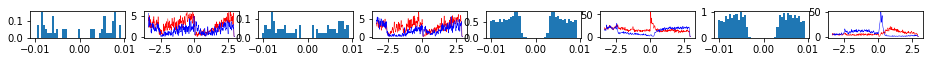

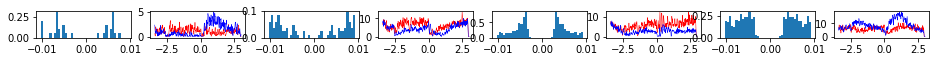

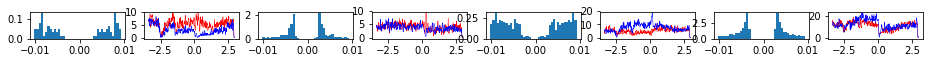

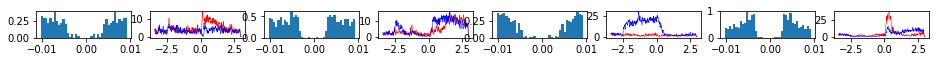

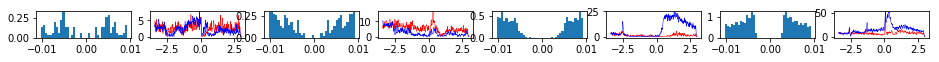

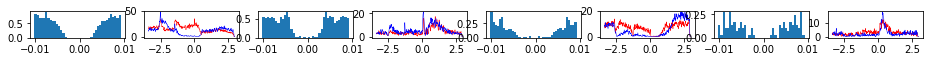

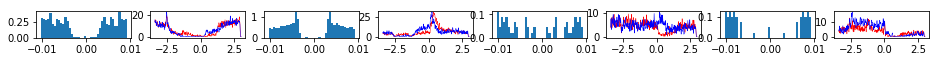

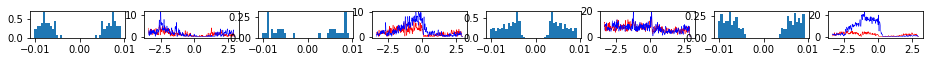

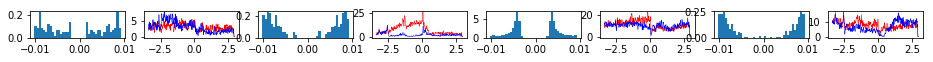

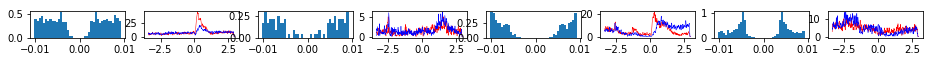

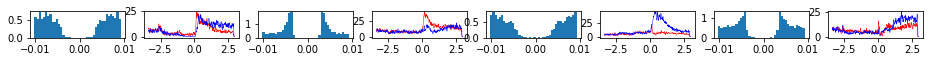

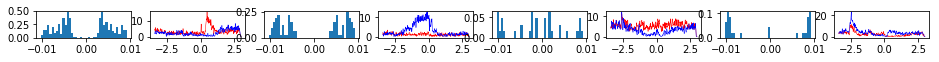

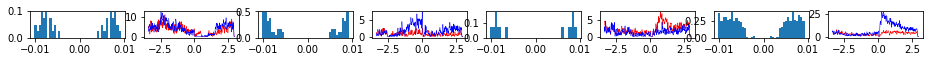

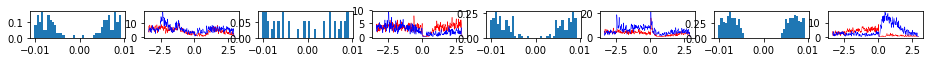

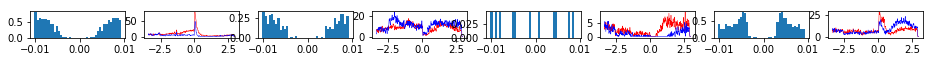

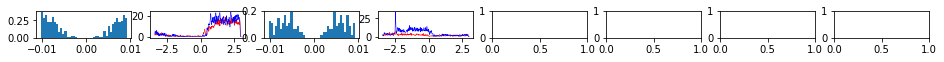

In [110]:
for psth_chunks in  split_list(lh_PTupper_units_psth, 4):
    fig, axes = plt.subplots(1, 8, figsize=(16, 0.5))
    for idx, isi_psth_dict in enumerate(psth_chunks):
        plot_psth_isi(isi_psth_dict, axes[idx*2:idx*2+2])

### Extended Data Fig5b - PTlower - Left ALM

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


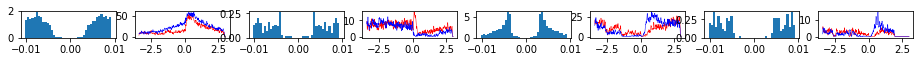

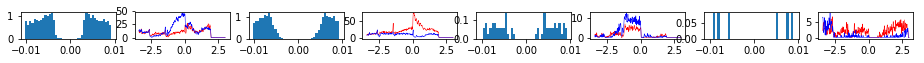

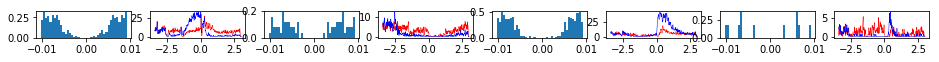

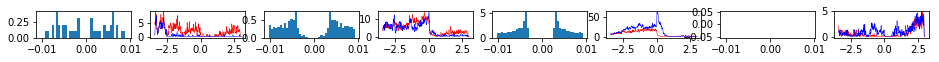

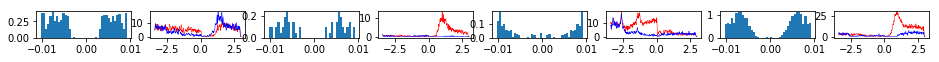

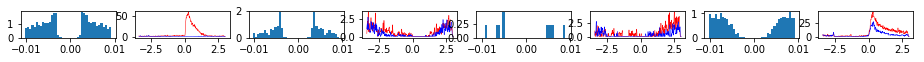

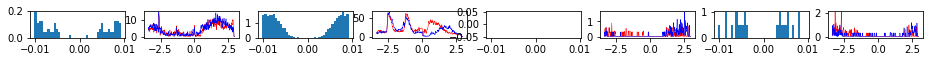

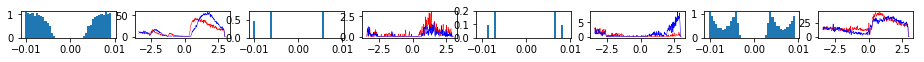

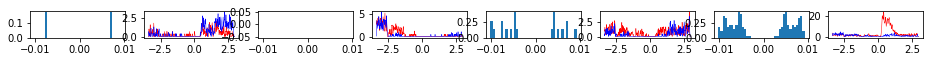

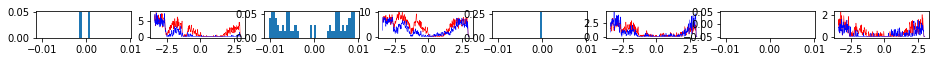

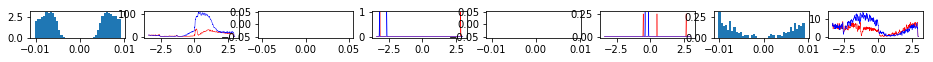

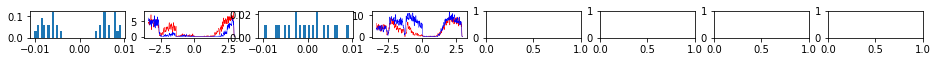

In [112]:
for psth_chunks in  split_list(lh_PTlower_units_psth, 4):
    fig, axes = plt.subplots(1, 8, figsize=(16, 0.5))
    for idx, isi_psth_dict in enumerate(psth_chunks):
        plot_psth_isi(isi_psth_dict, axes[idx*2:idx*2+2])

### Extended Data Fig5b - PTlower - Right ALM

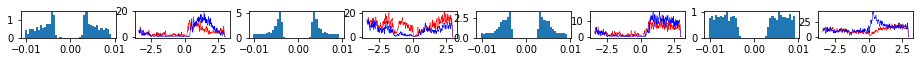

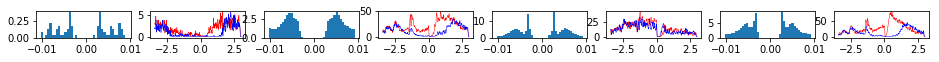

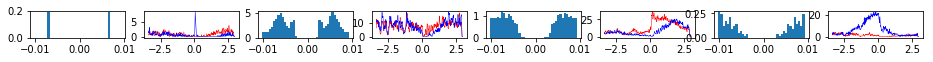

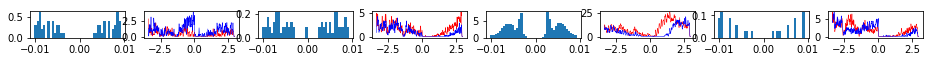

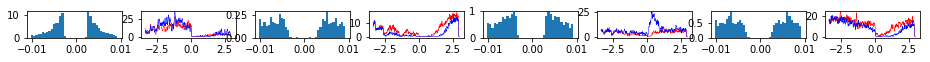

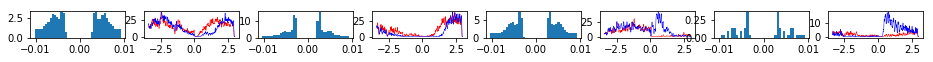

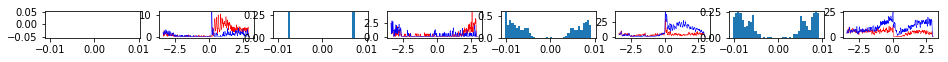

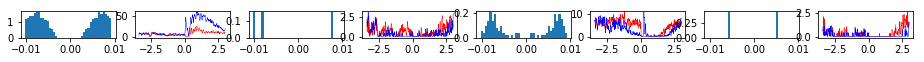

In [113]:
for psth_chunks in  split_list(rh_PTlower_units_psth, 4):
    fig, axes = plt.subplots(1, 8, figsize=(16, 0.5))
    for idx, isi_psth_dict in enumerate(psth_chunks):
        plot_psth_isi(isi_psth_dict, axes[idx*2:idx*2+2])